In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Data Science Competition 2023

## What do we want to know using this data?

We decided we want to investigate what organisms live in what conditions.
- Can we somehow cluster them by water conditions? 
- Can we predict the percentage of each specie by the conditions? ML?


## Analyzing our data:

Look at correlation between the water conditions we have. Which ones are related to each other?

In [15]:
#cross correlation code....

We have many different scientific names and the % doesn't add up to a 100 because many are repeated because they represent a subgroup of something already represented. Also there is some overlap so they won't add up.

# How does the different type of system and treatments impact the life that is in it?

# Analyzing biodiversity:

First we have to define a measure of diversity.
Thanks to chatGPTs recomendation we found the Shannon-Wiener Diversity Index (H').
This is defined by the equation H = -Σpi * ln(pi) where pi is the proportion of each individual in the community.

Problem. The % when looking by species does not add up and if you add it gives a different value each time.
We'll normalize it at each time stamp so it matches 100% when calculating.

In [16]:
abd_df = pd.read_csv("competition_dataset/abundance_table2.csv")
abd_df.head()

,Scientific Name,Taxonomic Rank,A0,A1_1A,A1_1B,A1_1C,A1_2A,A1_2B,A1_2C,A1_3A,...,B9_1A,B9_1B,B9_1C,B9_2A,B9_2B,B9_2C,B9_3A,B9_3B,B9_3BR,B9_3C
0,Homo sapiens,S,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
1,Homo,G,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
2,Homininae,F1,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
3,Hominidae,F,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
4,"""""Hominoidea",O4,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03


In [17]:
#Split by specie:
ranks = ["S"]
diversitys = {}
for rank in ranks:
    #filter by taxonomic rank ang get out non needed columns
    onlypercents = abd_df[abd_df["Taxonomic Rank"] == rank].drop(["Scientific Name","Taxonomic Rank"],axis=1)
    for col in onlypercents.columns:
        #normalize to per selected rank
        normalized = onlypercents[col]/onlypercents[col].sum()
        
        #calculate diversity meausure:
        div = -np.sum(normalized*np.log(normalized))
        diversitys[col] = div

/Users/josepsmachine/miniforge3/envs/chaos/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
#Convert A0 to A0_0A for convenience
aux = diversitys["A0"] 
diversitys.pop("A0")
diversitys["A0_0A"] = aux

In [19]:
#Create pandas df from this, separate each value
div_df= pd.DataFrame(diversitys.items(), columns=['Sample', 'diversity'])

div_df['System'] = div_df['Sample'].str.extract(r'(\D)')[0]
div_df['Treatment_Type'] = div_df['Sample'].str.extract(r'(\d+)')[0].astype(int)
div_df['Time_Stamp'] = div_df['Sample'].str.extract(r'_(\d+)')[0].astype(int)
div_df['Replica'] = div_df['Sample'].str[-1]

print(div_df)

     Sample  diversity System  Treatment_Type  Time_Stamp Replica
0     A1_1A   5.932745      A               1           1       A
1     A1_1B   5.966684      A               1           1       B
2     A1_1C   5.929311      A               1           1       C
3     A1_2A   5.687519      A               1           2       A
4     A1_2B   5.470043      A               1           2       B
..      ...        ...    ...             ...         ...     ...
118   B9_3A   5.250234      B               9           3       A
119   B9_3B   5.385868      B               9           3       B
120  B9_3BR   5.356141      B               9           3       R
121   B9_3C   5.312900      B               9           3       C
122   A0_0A   0.884724      A               0           0       A

[123 rows x 6 columns]


Turn around pandas df so we have for each column a time stamp:

In [20]:
import pandas as pd

# Assuming your original DataFrame is named 'df'
# Create a new column for the 't' values
div_df['t'] = 't' + div_df['Time_Stamp'].astype(str)

# Pivot the DataFrame to create a new one
pivot_df = div_df.pivot(index=['System', 'Treatment_Type', 'Replica'], columns='t', values='diversity').reset_index()

# Rename the columns
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={'System': 'System', 'Treatment_Type': 'Treatment', 'Replica': 'Replica'})

# Display the resulting DataFrame
pivot_df.head()


,System,Treatment,Replica,t0,t1,t2,t3
0,A,0,A,0.884724,NaN,NaN,NaN
1,A,1,A,NaN,5.932745,5.687519,5.434151
2,A,1,B,NaN,5.966684,5.470043,5.473904
3,A,1,C,NaN,5.929311,5.423927,5.533007
4,A,2,A,NaN,5.612104,5.434575,NaN


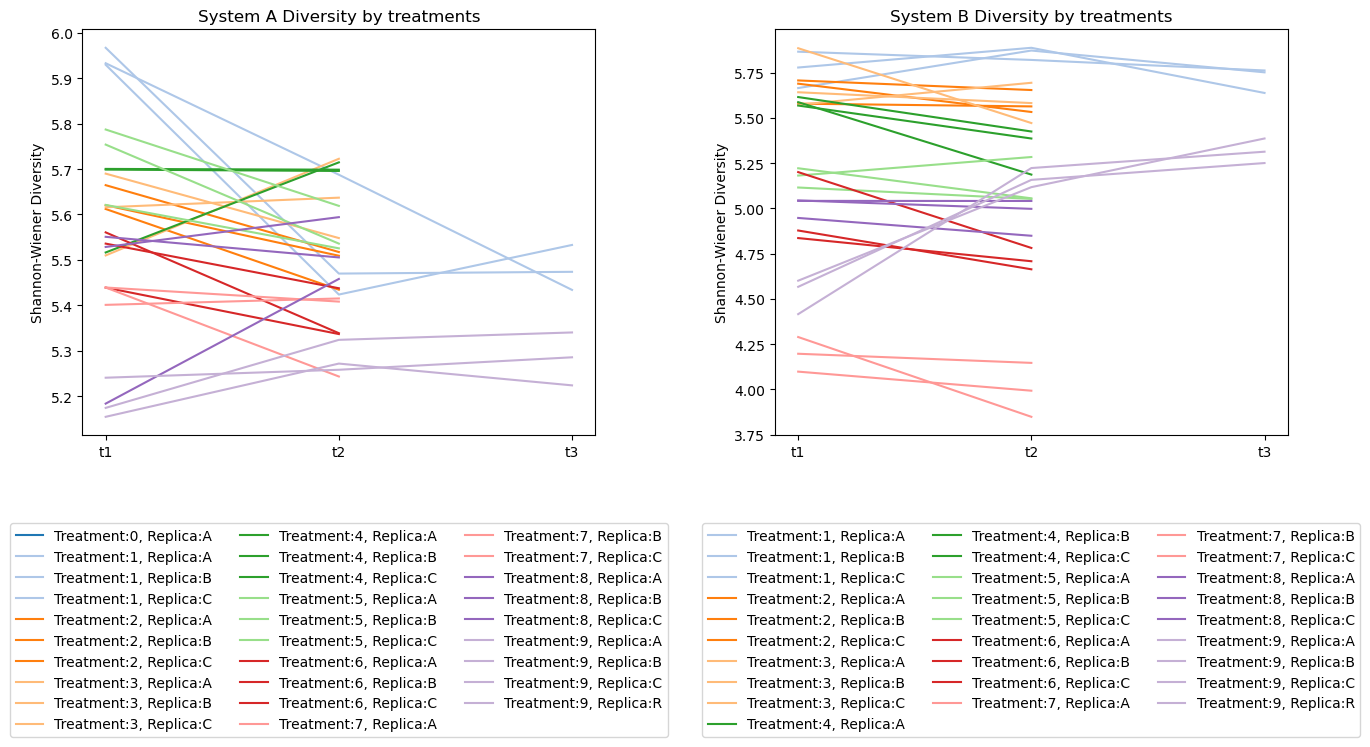

In [21]:
# Create a color dictionary based on unique treatment values
unique_treatments = pivot_df['Treatment'].unique()
color_dict = {treatment: plt.cm.tab20(i) for i, treatment in enumerate(unique_treatments)}

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 8))  # 1 row, 2 columns

# System A Plot
ax = axes[0]
for j, row in pivot_df[pivot_df["System"] == "A"].iterrows():
    treatment = row["Treatment"]
    color = color_dict[treatment]
    ax.plot(row[["t1", "t2", "t3"]], label=f'Treatment:{treatment}, Replica:{row["Replica"]}', color=color)
ax.set_title("System A Diversity by treatments")
ax.set_ylabel("Shannon-Wiener Diversity")
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.2))

# System B Plot
ax = axes[1]
for j, row in pivot_df[pivot_df["System"] == "B"].iterrows():
    treatment = row["Treatment"]
    color = color_dict[treatment]
    ax.plot(row[["t1", "t2", "t3"]], label=f'Treatment:{treatment}, Replica:{row["Replica"]}', color=color)
ax.set_title("System B Diversity by treatments")
ax.set_ylabel("Shannon-Wiener Diversity")
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.2))

plt.tight_layout()  # Automatically adjust subplot parameters to give enough space
plt.show()

Do we see any correlation with environmental variables?

In [22]:
#code correlation

# What are the main living organisms that are present? How are they affected by the different treatments?

Again, analyzing by species

In [23]:
by_specie_df = abd_df[abd_df["Taxonomic Rank"] == "S"]
by_specie_df.head()

,Scientific Name,Taxonomic Rank,A0,A1_1A,A1_1B,A1_1C,A1_2A,A1_2B,A1_2C,A1_3A,...,B9_1A,B9_1B,B9_1C,B9_2A,B9_2B,B9_2C,B9_3A,B9_3B,B9_3BR,B9_3C
0,Homo sapiens,S,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
6,Cicer arietinum,S,0.0,0.01,0.01,0.01,0.01,0.02,0.03,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
8,Glycine max,S,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,Glycine soja,S,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10,Medicago truncatula,S,0.0,0.01,0.01,0.01,0.01,0.02,0.02,0.01,...,0.01,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.01


Normalize the values, over their collective % sum

In [24]:
by_specie_df = abd_df[abd_df["Taxonomic Rank"] == "S"].copy()
for c in by_specie_df.columns[2:]:
    by_specie_df[c] = by_specie_df[c]/by_specie_df[c].sum()*100
by_specie_df.head()

,Scientific Name,Taxonomic Rank,A0,A1_1A,A1_1B,A1_1C,A1_2A,A1_2B,A1_2C,A1_3A,...,B9_1A,B9_1B,B9_1C,B9_2A,B9_2B,B9_2C,B9_3A,B9_3B,B9_3BR,B9_3C
0,Homo sapiens,S,0.0,0.262329,0.318878,0.286041,0.327225,0.447284,0.518135,0.831947,...,0.622084,0.624025,0.598802,0.632911,0.626305,0.641026,0.457666,0.442478,0.649351,0.649351
6,Cicer arietinum,S,0.0,0.052466,0.063776,0.057208,0.065445,0.127796,0.194301,0.166389,...,0.155521,0.156006,0.149701,0.210970,0.208768,0.213675,0.228833,0.221239,0.216450,0.216450
8,Glycine max,S,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Glycine soja,S,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.064767,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,Medicago truncatula,S,0.0,0.052466,0.063776,0.057208,0.065445,0.127796,0.129534,0.166389,...,0.155521,0.156006,0.149701,0.000000,0.208768,0.213675,0.000000,0.000000,0.000000,0.216450


To find the most present species in each sample we will grab the first quartile on each

In [25]:
thr = 0.95
thresholds = by_specie_df.quantile(q=[thr], axis=0, numeric_only=True).to_dict()
thresholds

{'A0': {0.95: 0.061236987140232714},
 'A1_1A': {0.95: 0.052465897166841545},
 'A1_1B': {0.95: 0.06377551020408163},
 'A1_1C': {0.95: 0.057208237986270026},
 'A1_2A': {0.95: 0.06544502617801047},
 'A1_2B': {0.95: 0.06389776357827476},
 'A1_2C': {0.95: 0.06476683937823834},
 'A1_3A': {0.95: 0.0},
 'A1_3B': {0.95: 0.0},
 'A1_3C': {0.95: 0.0},
 'A2_1A': {0.95: 0.0},
 'A2_1B': {0.95: 0.0},
 'A2_1C': {0.95: 0.0},
 'A2_2A': {0.95: 0.0},
 'A2_2B': {0.95: 0.0},
 'A2_2C': {0.95: 0.0},
 'A3_1A': {0.95: 0.0},
 'A3_1B': {0.95: 0.1408450704225352},
 'A3_1C': {0.95: 0.0},
 'A3_2A': {0.95: 0.1400560224089636},
 'A3_2B': {0.95: 0.0},
 'A3_2C': {0.95: 0.0},
 'A4_1A': {0.95: 0.1422475106685633},
 'A4_1B': {0.95: 0.0},
 'A4_1C': {0.95: 0.10744985673352435},
 'A4_2A': {0.95: 0.13368983957219252},
 'A4_2B': {0.95: 0.1443001443001443},
 'A4_2C': {0.95: 0.12468827930174566},
 'A5_1A': {0.95: 0.0},
 'A5_1B': {0.95: 0.12150668286755771},
 'A5_1C': {0.95: 0.13280212483399736},
 'A5_2A': {0.95: 0.0},
 'A5_2B': {0

With this we see that the data is very very sparse. We have many organisms that contribute a small percent.Note that the above values are in %

We'll do another approach. We'll compute this dataset for all species and then look at each of them and find if they have any trends.
 

In [37]:
#Original single threaded process
"""
from tqdm import tqdm

lenght = len(by_specie_df)
quarto = int(lenght/8)

chunks = []
for sep in range(0,8):
    df_rows = []
    indexed = []
    for i,row in tqdm(by_specie_df[quarto:quarto*sep+1].iterrows(),total=len(by_specie_df)):
        for col in by_specie_df.columns[3:]: #avoid also A0
            t = col[3]
            specie = row["Scientific Name"]
            id = specie + "_" + col[0]+col[1]+"_"+col[4:]

            if id not in indexed: #new row
                data_dict = {
                    "id": id,
                    "Specie": specie,
                    "System": col[0],
                    "Treatment": col[1],
                    "Replica": col[4:]
                }
                data_dict["t" + t] = row[col]
                df_rows.append(data_dict)
                indexed.append(id)

            else: #add
                idx = indexed.index(id)
                df_rows[idx]["t" + t] = row[col]
    chunks.append(df_rows)
"""

'\nfrom tqdm import tqdm\n\nlenght = len(by_specie_df)\nquarto = int(lenght/8)\n\nchunks = []\nfor sep in range(0,8):\n    df_rows = []\n    indexed = []\n    for i,row in tqdm(by_specie_df[quarto:quarto*sep+1].iterrows(),total=len(by_specie_df)):\n        for col in by_specie_df.columns[3:]: #avoid also A0\n            t = col[3]\n            specie = row["Scientific Name"]\n            id = specie + "_" + col[0]+col[1]+"_"+col[4:]\n\n            if id not in indexed: #new row\n                data_dict = {\n                    "id": id,\n                    "Specie": specie,\n                    "System": col[0],\n                    "Treatment": col[1],\n                    "Replica": col[4:]\n                }\n                data_dict["t" + t] = row[col]\n                df_rows.append(data_dict)\n                indexed.append(id)\n\n            else: #add\n                idx = indexed.index(id)\n                df_rows[idx]["t" + t] = row[col]\n    chunks.append(df_rows)\n'

Parallelize the process to make it faster

In [33]:
from tqdm import tqdm
import multiprocessing
from utils import process_chunk

# Set the number of processes to use (you can adjust this)
num_processes = 8

# Divide the data into chunks
length = len(by_specie_df)
quarto = int(length / num_processes)
chunks = [by_specie_df[quarto * i: quarto * (i + 1)] for i in range(num_processes)]

# Create a pool of worker processes
pool = multiprocessing.Pool(num_processes)

# Process the data in parallel using the pool of worker processes
results = pool.map(process_chunk, chunks)

# Close the pool of worker processes
pool.close()
pool.join()

# Combine the results from all the processes
combined_data = []
for result in results:
    combined_data.extend(result)

In [34]:
species_df = pd.DataFrame(combined_data)

In [41]:
species_df.to_csv("sample_by_specie_timewise.csv",index=False)

In [42]:
species_df = pd.read_csv("sample_by_specie_timewise.csv")
species_df

,id,Specie,System,Treatment,Replica,t1,t2,t3
0,Homo sapiens_A1_A,Homo sapiens,A,1,A,0.262329,0.327225,0.831947
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,NaN
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,NaN
...,...,...,...,...,...,...,...,...
684987,Heterocapsa circularisquama DNA virus 01_B8_C,Heterocapsa circularisquama DNA virus 01,B,8,C,NaN,NaN,NaN
684988,Heterocapsa circularisquama DNA virus 01_B9_A,Heterocapsa circularisquama DNA virus 01,B,9,A,NaN,NaN,NaN
684989,Heterocapsa circularisquama DNA virus 01_B9_B,Heterocapsa circularisquama DNA virus 01,B,9,B,NaN,NaN,NaN
684990,Heterocapsa circularisquama DNA virus 01_B9_C,Heterocapsa circularisquama DNA virus 01,B,9,C,NaN,NaN,NaN


Looking at more present species by SYSTEM for all timestamps: (by mean value)

In [47]:
thr = 0.5
system_filts = species_df[species_df["System"] == "A"]
mean_vals = system_filts[["t1","t2","t3"]].mean(axis=1).to_numpy()
idxs = np.where(mean_vals > thr)
system_filts.iloc[idxs]

,id,Specie,System,Treatment,Replica,t1,t2,t3
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,NaN
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,NaN
5,Homo sapiens_A2_C,Homo sapiens,A,2,C,0.457317,0.710480,NaN
...,...,...,...,...,...,...,...,...
625319,Woeseia oceani_A8_C,Woeseia oceani,A,8,C,1.785714,2.699055,NaN
625320,Woeseia oceani_A9_A,Woeseia oceani,A,9,A,3.361345,5.689655,6.122449
625321,Woeseia oceani_A9_B,Woeseia oceani,A,9,B,3.780069,4.571429,3.607214
625322,Woeseia oceani_A9_C,Woeseia oceani,A,9,C,3.374233,4.448743,5.543710


In [54]:
most_common_sysA = system_filts.iloc[idxs]["Specie"].unique()

In [55]:
thr = 0.5
system_filts = species_df[species_df["System"] == "B"]
mean_vals = system_filts[["t1","t2","t3"]].mean(axis=1).to_numpy()
idxs = np.where(mean_vals > thr)
system_filts.iloc[idxs]

,id,Specie,System,Treatment,Replica,t1,t2,t3
32,Homo sapiens_B2_B,Homo sapiens,B,2,B,0.468750,0.574713,NaN
33,Homo sapiens_B2_C,Homo sapiens,B,2,C,0.502513,0.515464,NaN
49,Homo sapiens_B8_A,Homo sapiens,B,8,A,0.684932,0.581395,NaN
50,Homo sapiens_B8_B,Homo sapiens,B,8,B,0.705219,0.658617,NaN
51,Homo sapiens_B8_C,Homo sapiens,B,8,C,0.688705,0.570776,NaN
...,...,...,...,...,...,...,...,...
625350,Woeseia oceani_B9_C,Woeseia oceani,B,9,C,0.748503,2.564103,3.679654
625351,Woeseia oceani_B9_BR,Woeseia oceani,B,9,BR,NaN,NaN,3.246753
628537,Yoonia vestfoldensis_B8_A,Yoonia vestfoldensis,B,8,A,0.684932,0.697674,NaN
628538,Yoonia vestfoldensis_B8_B,Yoonia vestfoldensis,B,8,B,0.705219,0.658617,NaN


In [56]:
most_common_sysB = system_filts.iloc[idxs]["Specie"].unique()

Lets see if we find differences in the species:

In [60]:
AminusB = set(most_common_sysA).intersection(set(most_common_sysB))
BminusA = set(most_common_sysB).intersection(set(most_common_sysA))
print("In the most common species, above 0.5%")
print(f"A filtered group contains: {len(most_common_sysA)} species")
print(f"B filtered group contains: {len(most_common_sysB)} species")
print(f"there are {len(AminusB)} species that are in A and not in B")
print(f"there are {len(BminusA)} species that are in B and not in A")

In the most common species, above 0.5%
A filtered group contains: 37 species
B filtered group contains: 71 species
there are 36 species that are in A and not in B
there are 36 species that are in B and not in A


Now we'll analyze the trend of the values, first, note that the values Nan Will now be completed with 0. Assuming that for that sample if there is no value for that specie it will just be set to 0.

In [63]:
species_df = species_df.fillna(0.0)
species_df.head()

,id,Specie,System,Treatment,Replica,t1,t2,t3
0,Homo sapiens_A1_A,Homo sapiens,A,1,A,0.262329,0.327225,0.831947
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,0.000000
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,0.000000


Calculate trend by applying linear regression and calculating the slope. We will also gather some extra data such as the mean or the variance of the data.

In [68]:
for index, row in tqdm(species_df.iterrows(),total=len(species_df)):
    y = np.array([row['t1'], row['t2'], row['t3']])
    x = np.array([0, 1, 2])  # Assuming t1, t2, and t3 correspond to time points 0, 1, and 2
    
    # Fit a linear regression model
    slope, _ = np.polyfit(x, y, 1)  #degree 1

    species_df.at[index, 'slope'] = slope

    #calculate extra measures
    species_df.at[index, 'var'] = y.var()
    species_df.at[index, 'std'] = y.std()
    species_df.at[index, 'mean'] = y.mean()


100%|██████████| 684992/684992 [02:10<00:00, 5229.13it/s]


In [69]:
species_df.head()

,id,Specie,System,Treatment,Replica,t1,t2,t3,slope,var,std,mean
0,Homo sapiens_A1_A,Homo sapiens,A,1,A,0.262329,0.327225,0.831947,0.284809,0.064824,0.254606,0.473834
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915,0.311519,0.072147,0.268602,0.569359
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994,0.222476,0.033018,0.181708,0.511723
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,0.000000,-0.320513,0.084277,0.290305,0.409370
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,0.000000,-0.364964,0.095881,0.309646,0.424468


In [76]:
dot_size = 5

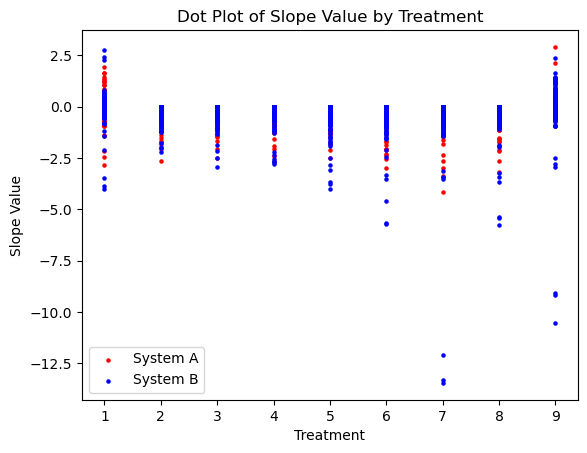

In [77]:
df_system_a = species_df[species_df['System'] == 'A']
df_system_b = species_df[species_df['System'] == 'B']

# Create a dot plot for System A
plt.scatter(df_system_a['Treatment'], df_system_a['slope'], c='red', label='System A',s=dot_size)

# Create a dot plot for System B
plt.scatter(df_system_b['Treatment'], df_system_b['slope'], c='blue', label='System B',s=dot_size)

# Set labels and title
plt.xlabel('Treatment')
plt.ylabel('Slope Value')
plt.title('Dot Plot of Slope Value by Treatment')

# Add a legend
plt.legend()

# Show the plot
plt.show()

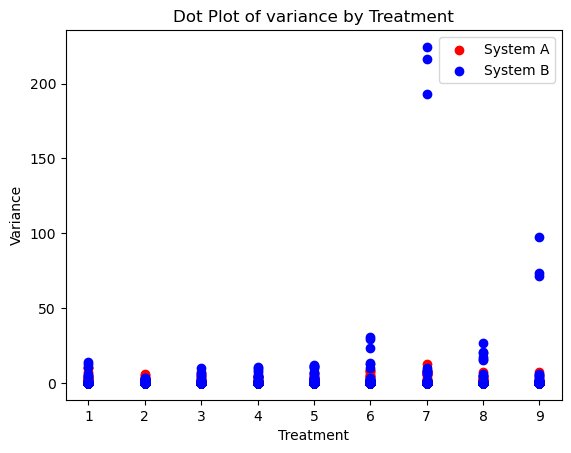

In [71]:
df_system_a = species_df[species_df['System'] == 'A']
df_system_b = species_df[species_df['System'] == 'B']

# Create a dot plot for System A
plt.scatter(df_system_a['Treatment'], df_system_a['var'], c='red', label='System A',s=dot_size)

# Create a dot plot for System B
plt.scatter(df_system_b['Treatment'], df_system_b['var'], c='blue', label='System B',s=dot_size)

# Set labels and title
plt.xlabel('Treatment')
plt.ylabel('Variance')
plt.title('Dot Plot of variance by Treatment')

# Add a legend
plt.legend()

# Show the plot
plt.show()

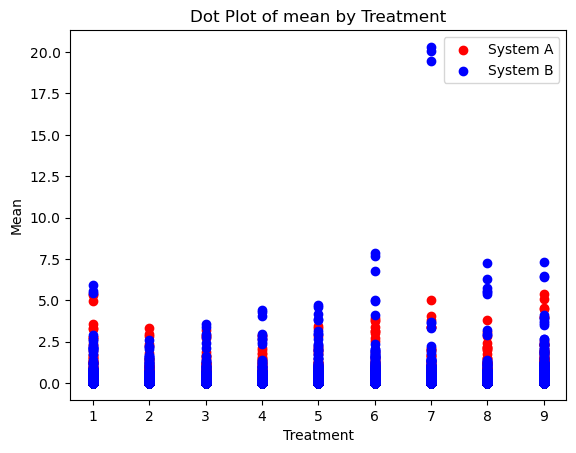

In [72]:
df_system_a = species_df[species_df['System'] == 'A']
df_system_b = species_df[species_df['System'] == 'B']

# Create a dot plot for System A
plt.scatter(df_system_a['Treatment'], df_system_a['mean'], c='red', label='System A',s=dot_size)

# Create a dot plot for System B
plt.scatter(df_system_b['Treatment'], df_system_b['mean'], c='blue', label='System B',s=dot_size)

# Set labels and title
plt.xlabel('Treatment')
plt.ylabel('Mean')
plt.title('Dot Plot of mean by Treatment')

# Add a legend
plt.legend()

# Show the plot
plt.show()

What if we only look at the most common?
What if we look wat the ones with higher of "measure value" mean variance slope

In [ ]:
#todo

# ANOVA analysis to identify how treatments affect species trend

First we'll decide on a subset of species to focus on, we'll look concretelly at humans as an example but different species can be easelly analyzed.

In [80]:
target_specie = "Homo sapiens"

In [82]:
#filter by specie
filt_specie = species_df[species_df['Specie'] == target_specie]
filt_specie.head()

,id,Specie,System,Treatment,Replica,t1,t2,t3,slope,var,std,mean
0,Homo sapiens_A1_A,Homo sapiens,A,1,A,0.262329,0.327225,0.831947,0.284809,0.064824,0.254606,0.473834
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915,0.311519,0.072147,0.268602,0.569359
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994,0.222476,0.033018,0.181708,0.511723
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,0.000000,-0.320513,0.084277,0.290305,0.409370
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,0.000000,-0.364964,0.095881,0.309646,0.424468


In [90]:
from scipy.stats import f_oneway

slope_by_treats = []
unique_treatments = filt_specie["Treatment"].unique()
for treatment in unique_treatments:
    #filter by treatment
    filt_t = filt_specie[filt_specie["Treatment"] == treatment]
    slope_by_treats.append(filt_t["slope"])

f_oneway(*slope_by_treats)

F_onewayResult(statistic=35.111865938873095, pvalue=2.6465857201236147e-17)

Typically we would have a significance level of 0.05 as our null hypotheses.
The output pvalue is greatly smallet than that, indicating that there is some statistical significance between the trend of the concentration of target specie and and the applied treatment.

Anyhow, might this aswell just be true for all species? Lets compute for all and plot :)

In [92]:
all_species = species_df["Specie"].unique()
results_pval = {}
for target in tqdm(all_species):
    #filter by specie
    filt_specie = species_df[species_df['Specie'] == target]
    slope_by_treats = []
    unique_treatments = filt_specie["Treatment"].unique()
    for treatment in unique_treatments:
        #filter by treatment
        filt_t = filt_specie[filt_specie["Treatment"] == treatment]
        slope_by_treats.append(filt_t["slope"])

    results_pval[target] = f_oneway(*slope_by_treats)[1]

100%|██████████| 12232/12232 [04:05<00:00, 49.87it/s]


In [94]:
#save to json, this took +3min :O
with open("p_value_treatment_by_species.json", "w") as fp:
    json.dump(results_pval , fp) 

In [4]:
with open("p_value_treatment_by_species.json", "r") as fp:
    results_pval = json.load(fp)

Colored by different taxonomic ranks:

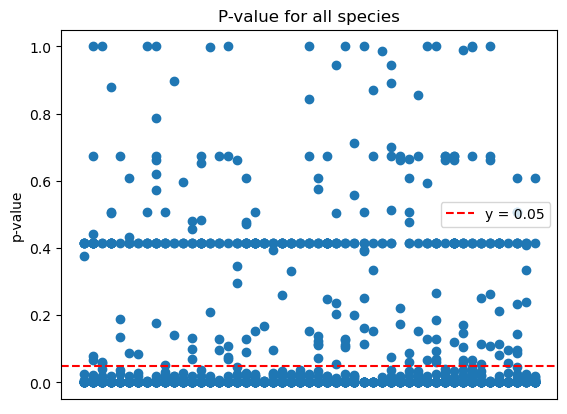

In [15]:
# Extract the y-values
y_values = [value for value in results_pval.values() if not np.isnan(value)]

# Calculate evenly distributed x-values
x_values = np.random.randint(0, 51, size=len(y_values))

# Create the scatter plot
plt.scatter(x_values, y_values)

# Set labels and title
plt.ylabel('p-value')
plt.title('P-value for all species')
plt.xticks([])

# Plot a dotted line at y = 0.05
plt.axhline(y=0.05, color='r', linestyle='--', label='y = 0.05')

plt.legend()
# Show the plot
plt.show()

We can see that for most of them the treatment type is significant in the trend.

What % exactly though?

In [14]:
sig_p_thr = 0.05
n_sign = len(np.where(np.array(list(results_pval.values())) > sig_p_thr)[0])
percent = n_sign / len(results_pval.values()) * 100

print(f"The treatment is significant in the trend of their 'population' for the {percent}% of species.")

The treatment is significant in the trend of their 'population' for the 2.934924787442773% of species.


Ok, not "Most" of them, so probably the treatment actually has some relevance.

What about kingdoms? If we plot the same p-significance value and color the species by different kingdoms they are part of do we see a pattern?

In [ ]:
#todo

# ANOVA analysis to identify how the two different systems affect species trend.